In [3]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


csv_file_path = '/Users/shubhibhadauriya/Desktop/Diss Project/001 2/001_0.csv'
image_base_path = '/Users/shubhibhadauriya/Desktop/Diss Project/0'  # Point to the directory containing images


data = pd.read_csv(csv_file_path)


print(data.head())
print("Columns in DataFrame:", data.columns)

data = data.dropna()


image_width, image_height = 640, 480
data['lx'] = data['lx'] / image_width
data['ly'] = data['ly'] / image_height
data['rx'] = data['rx'] / image_width
data['ry'] = data['ry'] / image_height


features = ['lx', 'ly', 'rx', 'ry']


def find_image_file(csv_filename, image_dir):
    
    parts = csv_filename.split('/')
    timestamp_id = parts[-1].split('-')[0]  

    
    corrected_timestamp_id = timestamp_id.replace(':', '/')
    
    
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if corrected_timestamp_id in file:
                return os.path.join(root, file)
    return None  


def load_images(filenames, base_path):
    images = []
    for filename in filenames:
        img_path = find_image_file(filename, base_path)
        if img_path and os.path.exists(img_path):
            img = load_img(img_path, target_size=(image_height, image_width), color_mode='rgb')
            img_array = img_to_array(img)
            images.append(img_array)
        else:
            print(f"File not found for CSV entry: {filename}")
            images.append(np.zeros((image_height, image_width, 3)))  # Insert a blank image if not found
    return np.array(images)


filenames = data['filename'].values
X_images = load_images(filenames, image_base_path)


y = data[features].values


if X_images.shape[0] != y.shape[0]:
    raise ValueError(f"Inconsistent number of images ({X_images.shape[0]}) and labels ({y.shape[0]}).")


X_train, X_temp, y_train, y_temp = train_test_split(X_images, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

2024-08-14 00:18:26.591952: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


   Unnamed: 0                                    filename  LE_left  LE_top  \
0           0  001/0/2022-09-26 08:07:22.792702-37704.jpg      131     410   
1           1  001/0/2022-09-26 08:07:23.101953-37752.jpg      163     479   
2           2  001/0/2022-09-26 08:07:22.818864-37708.jpg      130     410   
3           3  001/0/2022-09-26 08:07:23.225207-37772.jpg      183     523   
4           4  001/0/2022-09-26 08:07:23.126469-37756.jpg      167     481   

   LE_right  LE_bottom  RE_left  RE_top  RE_right  RE_bottom   lx   ly   rx  \
0       375        525      633     429       856        545  252  470  766   
1       379        564      621     479       821        584  260  531  740   
2       373        525      632     431       854        547  255  471  763   
3       380        593      624     526       807        610  261  572  723   
4       379        566      622     480       822        583  262  540  733   

    ry  relative_lx  relative_ly  relative_rx  relative_

## CNN

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


initial_learning_rate = 0.0005  
epochs = 100  
batch_size = 32  

def build_cnn_model(learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(480, 640, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),  
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),  
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),  
        
        Flatten(),
        Dense(128, activation='relu'),  
        Dropout(0.5),  
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='linear')  
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


cnn_model = build_cnn_model(learning_rate=initial_learning_rate)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


cnn_history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                            validation_data=(X_val, y_val), 
                            epochs=epochs,
                            callbacks=[early_stopping, reduce_lr])

# Evaluate on test data
#cnn_test_loss, cnn_test_mae = cnn_model.evaluate(X_test, y_test)


Epoch 1/100


/Users/shubhibhadauriya/anaconda3/envs/tf_keras_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 180s 45s/step - loss: 170849.2969 - mae: 234.8098 - val_loss: 406.7745 - val_mae: 16.8653 - learning_rate: 5.0000e-04
Epoch 2/100


2024-08-14 01:42:04.797691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 2 of 8
2024-08-14 01:42:15.137141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:42:15.145474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 139s 24s/step - loss: 42591.2031 - mae: 160.6996 - val_loss: 164.0823 - val_mae: 11.9252 - learning_rate: 5.0000e-04
Epoch 3/100


2024-08-14 01:44:22.918550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:44:22.924973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 19s/step - loss: 11359.7207 - mae: 81.0764 - val_loss: 22.2678 - val_mae: 3.0557 - learning_rate: 5.0000e-04
Epoch 4/100


2024-08-14 01:45:50.258699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:45:50.261510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 18s/step - loss: 2474.1135 - mae: 38.5243 - val_loss: 6.1171 - val_mae: 2.1405 - learning_rate: 5.0000e-04
Epoch 5/100


2024-08-14 01:47:15.817377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:47:15.823536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 88s 19s/step - loss: 599.0321 - mae: 19.0298 - val_loss: 3.7839 - val_mae: 1.7625 - learning_rate: 5.0000e-04
Epoch 6/100


2024-08-14 01:48:43.195829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:48:43.198412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 88s 19s/step - loss: 127.8122 - mae: 9.1284 - val_loss: 2.6485 - val_mae: 1.4483 - learning_rate: 5.0000e-04
Epoch 7/100


2024-08-14 01:50:11.372231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:50:11.375182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 19s/step - loss: 38.6940 - mae: 5.0254 - val_loss: 2.1275 - val_mae: 1.2791 - learning_rate: 5.0000e-04
Epoch 8/100


2024-08-14 01:51:37.797809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:51:37.802399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 19s/step - loss: 23.4478 - mae: 3.8533 - val_loss: 1.8707 - val_mae: 1.1847 - learning_rate: 5.0000e-04
Epoch 9/100


2024-08-14 01:53:04.954339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:53:04.957310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 107s 25s/step - loss: 14.6505 - mae: 3.0566 - val_loss: 1.7043 - val_mae: 1.1210 - learning_rate: 5.0000e-04
Epoch 10/100


2024-08-14 01:54:56.445567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:54:56.448931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 130s 27s/step - loss: 13.8407 - mae: 2.9513 - val_loss: 1.5989 - val_mae: 1.0783 - learning_rate: 5.0000e-04
Epoch 11/100


2024-08-14 01:57:02.614741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:57:02.619884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 94s 21s/step - loss: 9.3413 - mae: 2.4388 - val_loss: 1.5125 - val_mae: 1.0427 - learning_rate: 5.0000e-04
Epoch 12/100


2024-08-14 01:58:36.111609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 01:58:36.117469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 93s 20s/step - loss: 9.5167 - mae: 2.3997 - val_loss: 1.2276 - val_mae: 0.9380 - learning_rate: 5.0000e-04
Epoch 13/100


2024-08-14 02:00:08.848024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:00:08.850710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 90s 19s/step - loss: 8.3956 - mae: 2.2957 - val_loss: 1.0630 - val_mae: 0.9661 - learning_rate: 5.0000e-04
Epoch 14/100


2024-08-14 02:01:38.934361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:01:38.938887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 95s 21s/step - loss: 3.9226 - mae: 1.5616 - val_loss: 0.4564 - val_mae: 0.5206 - learning_rate: 5.0000e-04
Epoch 15/100


2024-08-14 02:03:13.572510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:03:13.579243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 18s/step - loss: 1.4055 - mae: 0.9453 - val_loss: 0.6373 - val_mae: 0.7107 - learning_rate: 5.0000e-04
Epoch 16/100


2024-08-14 02:04:36.883918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:04:36.888880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 17s/step - loss: 0.6521 - mae: 0.6965 - val_loss: 0.4650 - val_mae: 0.5882 - learning_rate: 5.0000e-04
Epoch 17/100


2024-08-14 02:05:59.004528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:05:59.007529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 17s/step - loss: 0.5329 - mae: 0.6177 - val_loss: 0.3774 - val_mae: 0.5619 - learning_rate: 5.0000e-04
Epoch 18/100


2024-08-14 02:07:20.447001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:07:20.451383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 19s/step - loss: 0.6386 - mae: 0.6886 - val_loss: 0.3749 - val_mae: 0.5568 - learning_rate: 5.0000e-04
Epoch 19/100


2024-08-14 02:08:42.797258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:08:42.802772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 17s/step - loss: 0.5363 - mae: 0.6317 - val_loss: 0.4600 - val_mae: 0.5830 - learning_rate: 5.0000e-04
Epoch 20/100


2024-08-14 02:10:00.252958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:10:00.255556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 18s/step - loss: 0.5198 - mae: 0.6298 - val_loss: 0.5263 - val_mae: 0.6384 - learning_rate: 5.0000e-04
Epoch 21/100


2024-08-14 02:11:21.688114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:11:21.699029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 17s/step - loss: 0.5695 - mae: 0.6614 - val_loss: 0.4976 - val_mae: 0.6191 - learning_rate: 5.0000e-04
Epoch 22/100


2024-08-14 02:12:42.682594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:12:42.689793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 16s/step - loss: 0.5403 - mae: 0.6502 - val_loss: 0.4365 - val_mae: 0.5733 - learning_rate: 5.0000e-04
Epoch 23/100


2024-08-14 02:13:59.499530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:13:59.504147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 17s/step - loss: 0.4855 - mae: 0.6009 - val_loss: 0.4096 - val_mae: 0.5550 - learning_rate: 5.0000e-04
Epoch 24/100


2024-08-14 02:15:17.451639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:15:17.454091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 17s/step - loss: 0.5438 - mae: 0.6483 - val_loss: 0.4227 - val_mae: 0.5671 - learning_rate: 2.5000e-04
Epoch 25/100


2024-08-14 02:16:36.204387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:16:36.211433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 16s/step - loss: 0.5083 - mae: 0.6137 - val_loss: 0.4539 - val_mae: 0.5938 - learning_rate: 2.5000e-04
Epoch 26/100


2024-08-14 02:17:58.067416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:17:58.071157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 16s/step - loss: 0.4806 - mae: 0.5856 - val_loss: 0.4714 - val_mae: 0.6086 - learning_rate: 2.5000e-04
Epoch 27/100


2024-08-14 02:19:15.527284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:19:15.529909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 74s 15s/step - loss: 0.5476 - mae: 0.6398 - val_loss: 0.4735 - val_mae: 0.6113 - learning_rate: 2.5000e-04
Epoch 28/100


2024-08-14 02:20:29.420751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:344: Filling up shuffle buffer (this may take a while): 4 of 8
2024-08-14 02:20:29.423709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 76s 15s/step - loss: 0.4785 - mae: 0.5902 - val_loss: 0.4482 - val_mae: 0.5934 - learning_rate: 2.5000e-04


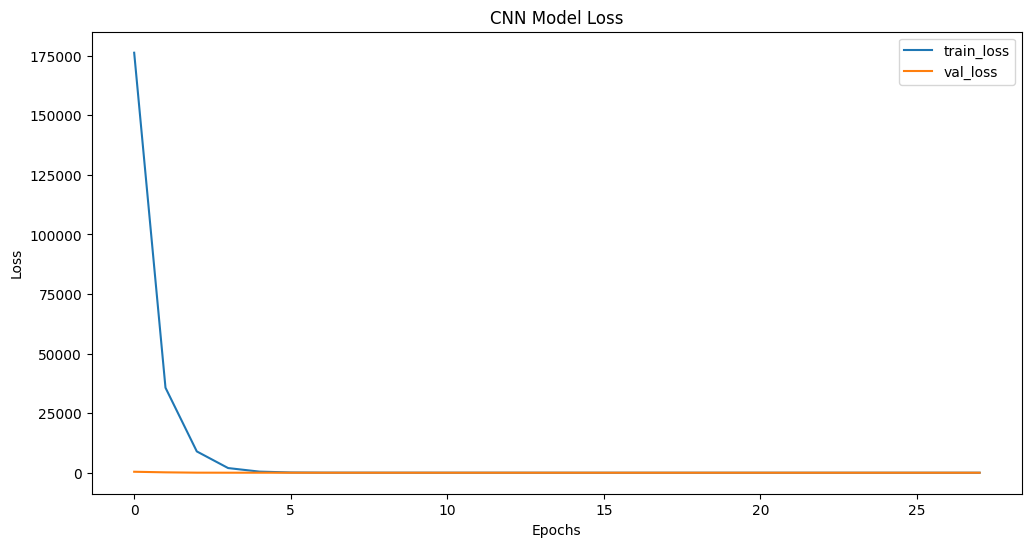

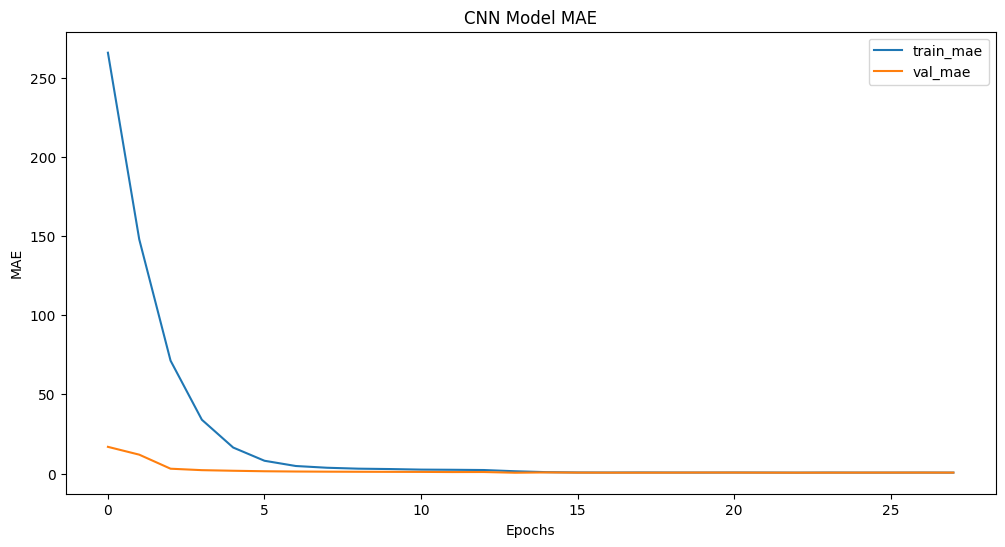

In [11]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='train_mae')
    plt.plot(history.history['val_mae'], label='val_mae')
    plt.title(f'{model_name} MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

# Plot histories
plot_history(cnn_history, 'CNN Model')
#plot_history(dense_history, 'Dense Model')
